In [89]:
import requests
from bs4 import BeautifulSoup as BS
import pandas as pd
import re
import time
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import numpy as np
from scipy.stats import chi2
sns.set_theme(style = 'dark', palette = 'Dark2')

In [34]:
URL = 'https://www.opensecrets.org/races/candidates?cycle=2020&id=TN07&spec=N'

response = requests.get(URL)

In [41]:
state = re.search(
    r'[A-Z][a-z]+(?: [A-Z][a-hj-z][a-z]+)?', 
    BS(response.text).findAll('title')[0].text 
)[0]
type(state)

str

In [36]:
district = re.search(
    r'District [0-9]{2}', 
    BS(response.text).findAll('title')[0].text
)[0]
type(district)

str

In [37]:
state_dict = {
    'State' : [state],
    'District' : [district]
}

In [38]:
pd.DataFrame.from_dict(state_dict)

,State,District
0,Tennessee,District 07


In [2]:
def district_scraper(state, district):
    URL = f'https://www.opensecrets.org/races/candidates?cycle=2020&id={state}{district}&spec=N'
    
    request_url = requests.get(URL)
    tm=0

    while request_url.status_code != 200:
        print('Waiting for ' + state + ' ' + district +'.')
        time.sleep(10)
        request_url = requests.get(URL)
        tm = tm + 1
        if tm == 10:
            break
    
    
    soup = BS(request_url.text)
    
    candidate_list = [x.text.strip() for x in soup.find_all('strong')]
    finances = (pd
        .read_html(
            str(soup.findAll('table', attrs={'class' : 'Members--table'}))
                .replace('$','')
                .replace(':', '')
        )
    )
    
    
    temp_df = pd.DataFrame()
    
    temp_df['name'] = [re.findall(r'(.+ .+) \(\w', item)[0] for item in candidate_list]
    
    temp_df['party'] = [re.findall(r'\((\w)\)', item)[0] for item in candidate_list]
    
    temp_df['state'] = str(re.search(r'[A-Z][a-z]+(?: [A-Z][a-z][a-rt-z][a-z]+)?',
                                     soup.findAll('title')[0].text)[0])
    
    temp_df['district'] = str(re.findall(r'District ([0-9]{2})', soup.findAll('title')[0].text)[0])
    
    temp_df['incumbent'] = ['Incumbent' if re.search(r'(Incumbent)', str(item)) != None 
                            else 'Not Incumbent' for item in candidate_list]
    
    temp_df['winner'] = ['Winner' if re.search(r'(Winner)', str(item)) is not None
                              else 'Not Winner' for item in candidate_list]
    
    temp_df['vote'] = [re.findall(r'(\d*[.?]\d*\%)', item)[0] for item in candidate_list]
    
    temp_df['raised'] = [finances[i].iloc[0,1] for i in range(len(candidate_list))]
    
    temp_df['spent'] = [finances[i].iloc[1,1] for i in range(len(candidate_list))]
    
    temp_df['cash_on_hand'] = [finances[i].iloc[2,1] for i in range(len(candidate_list))]
    
    global candidate_df
    candidate_df = pd.concat([candidate_df, temp_df])
    candidate_df = candidate_df.reset_index(drop=True)

In [3]:
district_dict = {
'AL': 7, 'AK': 1, 'AZ': 9, 'AR': 4, 'CA': 53, 'CO': 7, 'CT': 5, 'DE': 1,'FL': 27, 'GA': 14, 
'HI': 2, 'ID': 2, 'IL': 18, 'IN': 9, 'IA': 4, 'KS': 4, 'KY': 6, 'LA': 6, 'ME': 2, 'MD': 8,
'MA': 9, 'MI': 14, 'MN': 8, 'MS': 4, 'MO': 8, 'MT': 1, 'NE': 3, 'NV': 4, 'NH': 2, 'NJ': 12,
'NM': 3, 'NY': 27, 'NC': 13, 'ND': 1, 'OH': 16, 'OK': 5, 'OR': 5, 'PA': 18, 'RI': 2, 'SC': 7,
'SD': 1, 'TN': 9, 'TX': 36, 'UT': 4, 'VT': 1, 'VA': 11, 'WA': 10, 'WV': 3, 'WI': 8, 'WY': 1
}

In [4]:
def state_candidate(state = all, district = all):
    global candidate_df
    candidate_df = pd.DataFrame()
    global district_dict

    if state == all and district == all:
        for s, d in district_dict.items():
            for num in range(1, d + 1):
                district_scraper(str(s), str(num).zfill(2))
    
    elif district == all:
        for num in range(1, district_dict[state] + 1):
            district_scraper(str(state), str(num).zfill(2))
    
    elif state == all:
        for s, d in district_dict.items():
            try:   
                district_scraper(str(s), str(district).zfill(2))
            except:
                pass
    
    else:
        district_scraper(str(state), str(district).zfill(2))
    
    return candidate_df

In [14]:
state_candidate(all, all).to_csv('../data/all_candidates.csv')

waiting for MN07
waiting for MN07
waiting for MN07
waiting for MN07
waiting for MN07
waiting for MN07
waiting for MN07
waiting for WI06
waiting for WI06
waiting for WI06
waiting for WI06
waiting for WI06
waiting for WI06
waiting for WI06


In [46]:
all_candidates = pd.read_csv('../data/all_candidates.csv')

In [6]:
all_candidates.shape

(892, 11)

In [7]:
all_candidates[
    all_candidates['raised'].isin(all_candidates.groupby(['state', 'district'])['raised'].max())
].groupby('winner')['name'].count().sort_values(ascending = False)

winner
Winner        384
Not Winner     51
Name: name, dtype: int64

In [8]:
all_candidates[
    all_candidates['spent'].isin(all_candidates.groupby(['state', 'district'])['spent'].max())
].groupby('winner')['name'].count().sort_values(ascending = False)

winner
Winner        381
Not Winner     54
Name: name, dtype: int64

## Part c
Yes

In [9]:
all_candidates.loc[
    all_candidates['incumbent'] == 'Incumbent'
].groupby('winner')['name'].count().sort_values(ascending = False)

winner
Winner        371
Not Winner     15
Name: name, dtype: int64

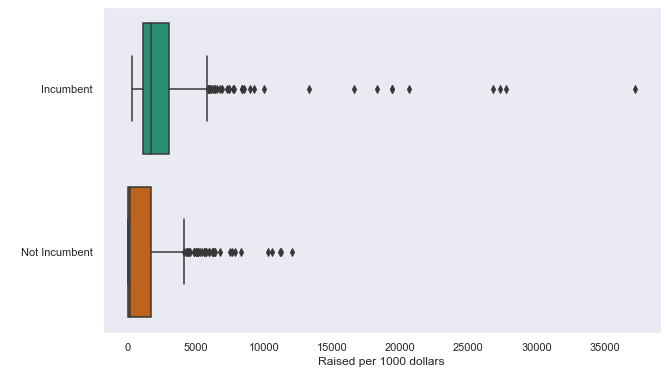

In [10]:
fig, ax = plt.subplots(figsize = (10,6))

sns.boxplot(
    data = all_candidates,
    x = all_candidates['raised'] / 1000,
    y = all_candidates['incumbent'].sort_values(),
    ax = ax
).set(
    xlabel='Raised per 1000 dollars', 
    ylabel = ' '
);

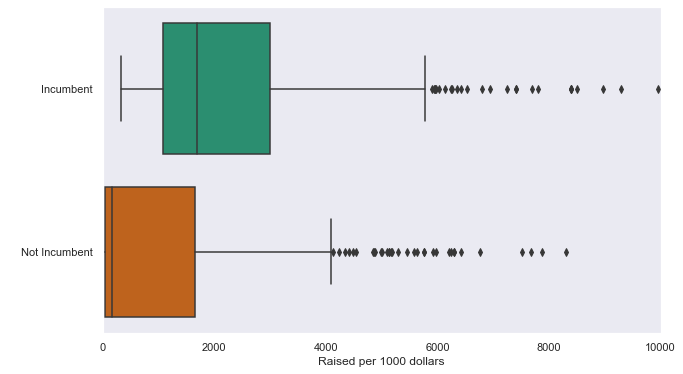

In [11]:
fig, ax = plt.subplots(figsize = (10,6))

sns.boxplot(
    data = all_candidates,
    x = all_candidates['raised'] / 1000,
    y = all_candidates['incumbent'].sort_values(),
    ax = ax
).set(
    xlabel='Raised per 1000 dollars', 
    ylabel = ' '
);
ax.set_xlim(0, 10000);

In [47]:
all_candidates = all_candidates.drop(columns = ['Unnamed: 0'])
all_candidates['winner_dum'] = pd.get_dummies(all_candidates['winner'])['Winner']
all_candidates['incumbent_dum'] = pd.get_dummies(all_candidates['incumbent'])['Incumbent']

In [48]:
win_incum_logreg = smf.logit("winner_dum ~ incumbent_dum",
                          data = all_candidates).fit()

Optimization terminated successfully.
         Current function value: 0.277630
         Iterations 7


In [49]:
win_incum_logreg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             winner_dum   No. Observations:                  892
Model:                          Logit   Df Residuals:                      890
Method:                           MLE   Df Model:                            1
Date:                Sat, 15 Oct 2022   Pseudo R-squ.:                  0.5991
Time:                        12:08:51   Log-Likelihood:                -247.65
converged:                       True   LL-Null:                       -617.78
Covariance Type:            nonrobust   LLR p-value:                5.229e-163
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -2.0060      0.138    -14.588      0.000      -2.275      -1.736
incumbent_dum     5.2141      0.297     17.550      0.000       4.632       5.796
=================================================================================
"""

In [82]:
np.exp(win_incum_logreg.params['incumbent_dum'])

183.8511111111114

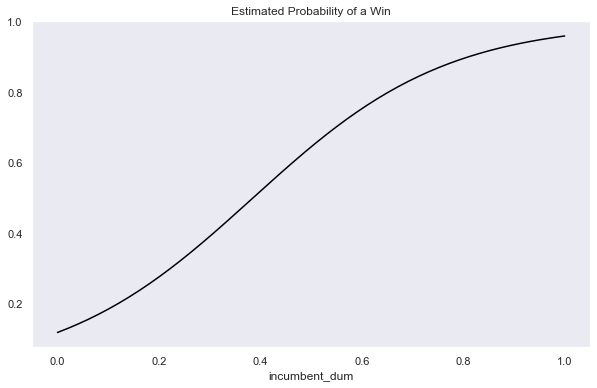

In [81]:
fit_df = pd.DataFrame({
    'incumbent_dum': np.linspace(start = all_candidates['incumbent_dum'].min(),
                            stop = all_candidates['incumbent_dum'].max(),
                            num = 150)
})

fit_df['fit'] = win_incum_logreg.predict(fit_df)

fit_df.plot(x = 'incumbent_dum',
             y = 'fit',
             legend = False,
             figsize = (10,6),
             color = 'black',
            title = 'Estimated Probability of a Win');

In [74]:
all_candidates['tot_money_spent'] =(all_candidates
.groupby(['state', 'district'])['spent']
.transform(sum)
)

In [76]:
all_candidates['percent_spent'] = (
    (all_candidates['spent'] / all_candidates['tot_money_spent'] * 100)
    .round(2)
)

In [77]:
win_per_spent_logreg = smf.logit("winner_dum ~ percent_spent",
                          data = all_candidates).fit()

Optimization terminated successfully.
         Current function value: 0.243753
         Iterations 8


In [100]:
win_incum_logreg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             winner_dum   No. Observations:                  892
Model:                          Logit   Df Residuals:                      890
Method:                           MLE   Df Model:                            1
Date:                Sat, 15 Oct 2022   Pseudo R-squ.:                  0.5991
Time:                        12:58:09   Log-Likelihood:                -247.65
converged:                       True   LL-Null:                       -617.78
Covariance Type:            nonrobust   LLR p-value:                5.229e-163
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -2.0060      0.138    -14.588      0.000      -2.275      -1.736
incumbent_dum     5.2141      0.297     17.550      0.000       4.632       5.796
=================================================================================
"""

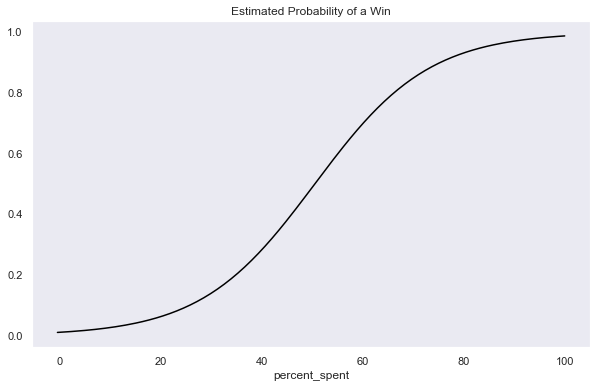

In [79]:
fit_df = pd.DataFrame({
    'percent_spent': np.linspace(start = all_candidates['percent_spent'].min(),
                            stop = all_candidates['percent_spent'].max(),
                            num = 150)
})

fit_df['fit'] = win_per_spent_logreg.predict(fit_df)

fit_df.plot(x = 'percent_spent',
             y = 'fit',
             legend = False,
             figsize = (10,6),
             color = 'black',
            title = 'Estimated Probability of a Win');

In [107]:
win_incum_per_spent_logreg = smf.logit("winner_dum ~ incumbent_dum + percent_spent",
                          data = all_candidates).fit()

Optimization terminated successfully.
         Current function value: 0.182460
         Iterations 8


In [85]:
reduced_model = smf.logit('winner_dum ~ 1',
                        data = all_candidates).fit()

Optimization terminated successfully.
         Current function value: 0.692582
         Iterations 3


In [87]:
def dd_test(reduced_model, full_model):
    G2 = -2 * (reduced_model.llf - full_model.llf)
    df = full_model.df_model - reduced_model.df_model
    return chi2.sf(G2, df = df)

In [97]:
dd_test(reduced_model, win_per_spent_logreg)

3.7812306868186874e-176

In [98]:
dd_test(reduced_model, win_incum_logreg)

5.228643940879279e-163

In [95]:
dd_test(win_per_spent_logreg, win_incum_per_spent_logreg)

1.363143088610387e-25

In [96]:
dd_test(win_incum_logreg, win_incum_per_spent_logreg)

8.252787790632775e-39

In [116]:
win_interact_incum_per_spent_logreg = smf.logit(
    "winner_dum ~ incumbent_dum + percent_spent + incumbent_dum:percent_spent",
                          data = all_candidates).fit()

Optimization terminated successfully.
         Current function value: 0.181388
         Iterations 8


In [117]:
dd_test(win_incum_per_spent_logreg, win_interact_incum_per_spent_logreg)

0.16656500582027997